Objetivo del notebook:
- Dataset con al menos 225 ejemplos
- Comparar etiquetado de los dos anotadores mediante IAA & Kappa
- Crear matriz de confusión para analizar diferencias entre los anotadores

In [163]:
# Importar librerías
import pandas as pd # PARA MANIPULAR DATAFRAMES
import numpy as np # PARA MANIPULAR MATRICES Y VECTORES
import spacy  # PARA PROCESAMIENTO DE LENGUAJE NATURAL
import seaborn as sns # PARA VISUALIZACIÓN DE DATOS
from collections import Counter # PARA CONTAR ELEMENTOS
from sklearn.metrics import f1_score,confusion_matrix,cohen_kappa_score # PARA EL CÁLCULO DE MÉTRICAS Y MEDIR ACUERDOS
from spacy.lang.es.stop_words import STOP_WORDS # PARA OBTENER LAS STOPWORDS EN ESPAÑOL
from sklearn.feature_extraction.text import TfidfVectorizer # PARA VECTORIZAR TEXTOS
import matplotlib.pyplot as plt # PARA VISUALIZACIÓN DE DATOS
from sklearn.decomposition import TruncatedSVD # PARA REDUCCIÓN DE DIMENSIONALIDAD
from sklearn.model_selection import train_test_split # PARA DIVIDIR LOS DATOS EN CONJUNTOS DE ENTRENAMIENTO Y PRUEBA
from sklearn.linear_model import LogisticRegression # PARA REGRESIÓN LOGÍSTICA
from sklearn.ensemble import RandomForestClassifier # PARA CLASIFICADOR DE BOSQUE ALEATORIO
from sklearn.svm import SVC # PARA CLASIFICADOR DE VECTORES DE SOPORTE
from sklearn.neighbors import KNeighborsClassifier # PARA CLASIFICADOR DE VECINOS MÁS CERCANOS
from sklearn.metrics import classification_report # PARA INFORMES DE CLASIFICACIÓN
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay





In [103]:
# Cargar y preparar datos
df = pd.read_excel('BBDD final final.xlsx')

# Mostrar el tamaño del DataFrame
print(f"Tamaño del DataFrame: {df.shape}")

# Mostrar los nombres de las columnas del DataFrame 
print('Nombres de las columnas:')
print(df.columns.tolist())


Tamaño del DataFrame: (226, 9)
Nombres de las columnas:
['Nombre del documento', 'id', 'Incidente', 'Descripción del Incidente', 'Fecha', 'Hora', 'Lesion', 'Clasificación Incidente | Diego', 'Clasificación Incidente | Carlos']


El siguiente paso será realizar un análisis comparativo entre las etiquetas que fueron aplicadas por nuestros especialistas, donde determinaremos cuantas coincidencias existen entre ellos, el balance de las clases; además podremos determinar que tan fuerte es el acuerdo entre los anotadores.

In [104]:
# Crear un nuevo DataFrame con las columnas que utilizaremos 'Descripción del Incidente', 'Clasificacion Incidente | Diego', 'Clasificacion Incidente | Carlos'
df_nuevo = df[['Descripción del Incidente', 'Clasificación Incidente | Diego', 'Clasificación Incidente | Carlos']]
# Mostrar el tamaño del nuevo DataFrame
print(f"Tamaño del nuevo DataFrame: {df_nuevo.shape}")

Tamaño del nuevo DataFrame: (226, 3)


In [105]:
# Mostrar las primeras filas del nuevo DataFrame
print('Primeras filas del nuevo DataFrame:')
df_nuevo.head()

Primeras filas del nuevo DataFrame:


,Descripción del Incidente,Clasificación Incidente | Diego,Clasificación Incidente | Carlos
0,Operador del terminal al momento de proceder a...,Bajo,Bajo
1,En faena de retiro de bomba de pozo profundo s...,Medio,Medio
2,Operador de empresa contratista mientras ponía...,Medio,Medio
3,Conductor de transporte de personal camino a s...,Grave,Grave
4,Guardia de seguridad informa que durante ronda...,Bajo,Bajo


In [106]:
# Cambiar el nombre a las columnas del nuevo DataFrame 
df_nuevo.columns = ['descripcion de incidente', 'Diego', 'Carlos']
# Mostrar los nombres de las columnas del nuevo DataFrame
print('Nombres de las columnas del nuevo DataFrame:')
print(df_nuevo.columns.tolist())
# Mostrar las primeras filas del nuevo DataFrame
print('Primeras filas del nuevo DataFrame:')
df_nuevo.head()

Nombres de las columnas del nuevo DataFrame:
['descripcion de incidente', 'Diego', 'Carlos']
Primeras filas del nuevo DataFrame:


,descripcion de incidente,Diego,Carlos
0,Operador del terminal al momento de proceder a...,Bajo,Bajo
1,En faena de retiro de bomba de pozo profundo s...,Medio,Medio
2,Operador de empresa contratista mientras ponía...,Medio,Medio
3,Conductor de transporte de personal camino a s...,Grave,Grave
4,Guardia de seguridad informa que durante ronda...,Bajo,Bajo


In [107]:
# Calcular el indice IAA (Indice Anotador de Acuerdo) entre las dos clasificaciones. 
average='weighted'
iaa_f1_score = f1_score(df_nuevo.Diego, df_nuevo.Carlos, average=average)
print(f'F1 Score({average}): {round(iaa_f1_score,2)}')

F1 Score(weighted): 0.94


In [108]:
# Calcular el índice de Kappa de Cohen entre las dos clasificaciones. 
iaa_kappa = cohen_kappa_score(df_nuevo.Diego, df_nuevo.Carlos)
print(f'Cohen Kappa: {round(iaa_kappa,2)}')

Cohen Kappa: 0.89


* Interpretación de los índices 

    - `F1 score` señala que existe una alta concordancia entre los anotadores.  
    - `Kappa`señala que un acuerdo casi perfecto entre los anotadores. 

In [109]:
# Calcular la matriz de confusión entre las dos clasificaciones. 
conf_matrix = confusion_matrix(df_nuevo.Diego, df_nuevo.Carlos)
print('Matriz de confusión:')

# Tranformar la matriz de confusión en un DataFrame para una mejor visualización
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=np.unique(df_nuevo.Diego), 
                              columns=np.unique(df_nuevo.Carlos))

# Mostrar la matriz de confusión
print(conf_matrix_df)

Matriz de confusión:
       Bajo  Grave  Medio
Bajo     58      0      6
Grave     0     21      0
Medio     7      0    134


* Interpretación de la matriz de confusión

    - `Coincidencias`: se identifican 213 coincidencias entre los anotadores. 
    - `No coincidencias`:  7 casos de “Medio” que Carlos marcó como “Bajo”. Ningún caso grave fue subestimado. Además, Carlos tiende levemente a sobrestimar más que subestimar, lo cual es preferible en escenarios de análisis de acciodentes. 

In [110]:
# Análisis de balance de las etiquetas entre los dos anotadores 
def balance_etiquetas(df, columna):
    conteo = Counter(df[columna])
    total = sum(conteo.values())
    balance = {etiqueta: (conteo[etiqueta] / total) * 100 for etiqueta in conteo}
    return balance

# Calcular el balance de etiquetas para Diego
balance_diego = balance_etiquetas(df_nuevo, 'Diego')
# Calcular el balance de etiquetas para Carlos
balance_carlos = balance_etiquetas(df_nuevo, 'Carlos')
# Mostrar el balance de etiquetas para Diego
print('Balance de etiquetas para Diego:')
print(balance_diego)
# Mostrar el balance de etiquetas para Carlos
print('Balance de etiquetas para Carlos:')
print(balance_carlos)



Balance de etiquetas para Diego:
{'Bajo': 28.31858407079646, 'Medio': 62.38938053097345, 'Grave': 9.29203539823009}
Balance de etiquetas para Carlos:
{'Bajo': 28.761061946902654, 'Medio': 61.94690265486725, 'Grave': 9.29203539823009}


El análisis de balance de las etiquetas entre los anotadores indica que son bastante parecidas y sus diferencias son marginales entre las clases.
La clase `grave` representa menos del 10% de los datos, lo que podría ser una señal de desbalance pero en general también es una situación esperable, dado que la empresa refuerza constantemente sus medidas de protección y seguridad. 


El anotador que clasifica es Carlos.  

# NPL

In [111]:
# Crear un nuevo dataframe con las columnas que utilizaremos para el análisis de texto 
df_NPL = df_nuevo[['descripcion de incidente', 'Carlos']]
# Cambiar el nombre a las columnas del nuevo DataFrame para NPL
df_NPL.columns = ['descripcion_incidente', 'etiqueta']
# Mostrar el tamaño del nuevo DataFrame para NPL
print(f"Tamaño del DataFrame para NPL: {df_NPL.shape}")
# Mostrar las primeras filas del nuevo DataFrame para NPL
print('Primeras filas del nuevo DataFrame para NPL:')
df_NPL.head()

Tamaño del DataFrame para NPL: (226, 2)
Primeras filas del nuevo DataFrame para NPL:


,descripcion_incidente,etiqueta
0,Operador del terminal al momento de proceder a...,Bajo
1,En faena de retiro de bomba de pozo profundo s...,Medio
2,Operador de empresa contratista mientras ponía...,Medio
3,Conductor de transporte de personal camino a s...,Grave
4,Guardia de seguridad informa que durante ronda...,Bajo


## Preprocesamiento : Tokenización | Lematizacion | 

In [112]:
# Cargar el modelo de lenguaje spaCy español largo para mejorar la cobertura (sin parser ni NER para más eficiencia)
nlp = spacy.load("es_core_news_lg", disable=["parser", "ner"])

# Definir función personalizada de tokenización y limpieza
def get_tokens(text):
    """
    Tokenización + lematización + limpieza:
    – Lemas en minúscula
    – Sin stop-words
    – Sin puntuación
    – Solo tokens alfabéticos
    – Sin URLs ni emails
    """
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.is_alpha
        and not token.is_stop
        and not token.is_punct
        and not token.like_url
        and not token.like_email
    ]
    return tokens

In [113]:
# Aplicar la función personalizada a cada documento
df_NPL['texto_procesado'] = df_NPL['descripcion_incidente'].apply(lambda x: ' '.join(get_tokens(x)))


A continuación validamos que el preprocesamiento ha sido aplicado correctamente. Utilizamos 10 muestras aleatorias y comparamos 

In [114]:
# Mostrar 10 ejemplos aleatorios
df_NPL[['descripcion_incidente', 'texto_procesado']].sample(10, random_state=1)


,descripcion_incidente,texto_procesado
39,Operador de fraccionamiento se encontraba en l...,operador fraccionamiento encontrar línea bidón...
167,Proyección de fragmentos durante proceso de co...,proyección fragmento proceso corte mecánico eq...
93,Durante la 2da jornada de lavado de tk 617 de ...,jornada lavado tk policloruro aluminio trabaja...
62,Durante maniobras en cubierta de embarcación R...,maniobra cubierta embarcación rocio v desprend...
196,Derrame accidental de producto químico en área...,derrame accidental producto químico área almac...
188,Desplazamiento inseguro en zona húmeda sin señ...,desplazamiento inseguro zona húmedo señalizaci...
38,Al momento de tapar galón con diluyente para p...,momento tapar galón diluyente pintura generar ...
122,Contacto involuntario con componente eléctrico...,contacto involuntario componente eléctrico ene...
105,Soldador de la empresa Holdas al momento de es...,soldador empresa holdas momento trabajo soldad...
89,Posterior a paso de Pig por línea 6 y 7 y ya c...,posterior paso pig línea flexible conectado tk...


In [116]:
# Calcular el número de tokens por texto procesado y mostrar estadísticas descriptivas
df_NPL['n_tokens'] = df_NPL['texto_procesado'].apply(lambda x: len(x.split()))
df_NPL['n_tokens'].describe()


count    226.000000
mean      22.756637
std        7.041343
min       10.000000
25%       20.000000
50%       21.000000
75%       23.000000
max       70.000000
Name: n_tokens, dtype: float64

In [117]:
# Contar las palabras más comunes, luego de aplicada la lematización. 
todos = ' '.join(df_NPL['texto_procesado']).split()
# Visualizar las palabras más comunes
print('Palabras más comunes:')
print( Counter(todos).most_common(10) )


# Indicar el total de palabras únicas
total_unicas = len(set(todos))
print(f'Total de palabras únicas: {total_unicas}')


Palabras más comunes:
[('trabajador', 101), ('área', 62), ('zona', 62), ('incidente', 58), ('operador', 51), ('encontrar', 51), ('momento', 48), ('producto', 44), ('sufrir', 38), ('tarea', 38)]
Total de palabras únicas: 1095


/var/folders/4p/ypjmz4gd4cj21t52_py1v1500000gn/T/ipykernel_47344/3649887455.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_NPL, x='etiqueta', y='n_tokens', palette=colores)


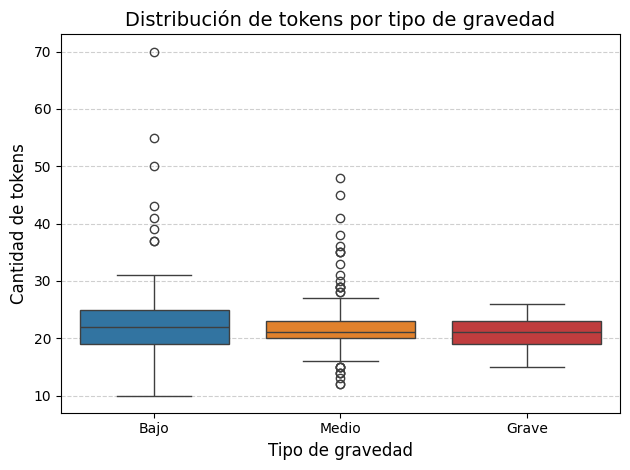

In [118]:
# Visualizar la distribución del número de tokens por tipo de gravedad
# Paleta de colores personalizada (puedes modificar los colores si lo deseas)
colores = {'Bajo': '#1f77b4', 'Medio': '#ff7f0e', 'Grave': '#d62728'}

# Crear el boxplot
sns.boxplot(data=df_NPL, x='etiqueta', y='n_tokens', palette=colores)

# Títulos y estilo
plt.title("Distribución de tokens por tipo de gravedad", fontsize=14)
plt.xlabel("Tipo de gravedad", fontsize=12)
plt.ylabel("Cantidad de tokens", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Aplicada el preprocesamiento y las técnicas de tokenización, limpieza y lematización, surgió la idea de evaluar la distribución de los tokens para identificar si la longitud de las descripciones de los incidentes podría tener una relación con la gravedad del incidente. 
Así es que construimos un boxplot el cual nos presenta la siguiente interpretación:

`Incidentes bajo`: poseen una mayor variabilidad en su longitud, lo que pudiera ser alguna señal de menor tensión (estrés) a la hora de declarar, o, porque se requiere que incorpore la mayor cantidad de contenido.

`Incidente medio`: poseen una menor variablidad en su longitud que en incidente bajo, pero aparece una alta dispersión. 

`Incidente grave`: poseen cierta homogenización en su longitud, probablemente como parte de algun protocolo se requiere que la descripción sea breve y clara. 

En sintesis, la longitud del texto parece reflejar, en parte, la percepción de gravedad del incidente, aunque no de forma determinante. Las descripciones más breves y homogéneas asociadas a casos graves podrían estar influenciadas por una mayor formalización del proceso de registro. 


## Representación vectorial | TF-IDF

In [126]:
# Crear representación vectorial o TF-IDF de los textos procesados

# Marcar la columa a vectorizar
columna_vectorizar = 'texto_procesado'

# Tokenizador personalizado
vectorizador = TfidfVectorizer(tokenizer=get_tokens, 
                               lowercase=False, 
                               preprocessor=None, 
                               token_pattern=None,
                               min_df=2,  # chao con los términos que aparecen menos de 2 veces
)
# Ajustar y transformar
vectorizador.fit(df_NPL[columna_vectorizar])
print("\nTamaño del vocabulario TF-IDF:", len(vectorizador.fit(df_NPL[columna_vectorizar])
.get_feature_names_out()))

# 4) Transformar la misma columna en la matriz TF-IDF
tfidf_vectors = vectorizador.transform(df_NPL[columna_vectorizar])
print("Dimensiones de la rep. vectorial:", tfidf_vectors.shape)




Tamaño del vocabulario TF-IDF: 467
Dimensiones de la rep. vectorial: (226, 467)


Trs la aplicación del modelo de vectorización, utilizando una tokenización personalizada, obtenemos como resultante una matriz de 226 documentos (filas) por 467 términos únicos (columnas). 

Cada una de las columnas representa un término lematizado que aparece en al menos dos registros, excliuendo singnos de puntuación, stopwords, emails y sitios web. 

A continuación presentamos una visualización de los términos que poseen mayor peso promedio en el método TF. La idaa es identificar los términos que apoartan mas información a los incidentes. 

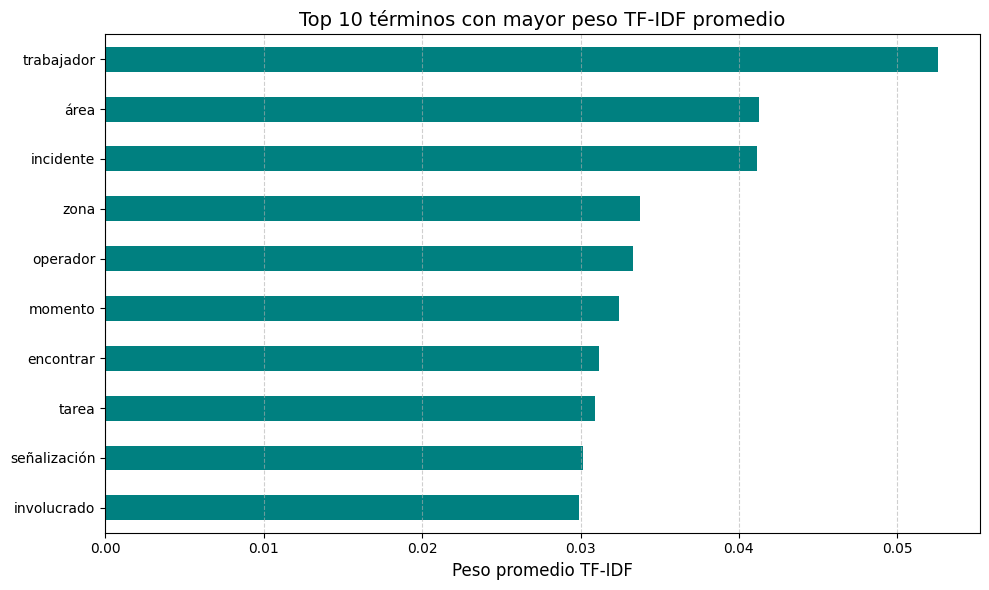

In [125]:
# Obtener los nombres de los términos
terminos = vectorizador.get_feature_names_out()

# Convertir la matriz TF-IDF en un DataFrame
df_tfidf = pd.DataFrame(tfidf_vectors.toarray(), columns=terminos)

# Calcular el peso promedio por término
peso_promedio = df_tfidf.mean().sort_values(ascending=False)

# Seleccionar los 10 términos más relevantes
top = peso_promedio.head(10)

# Graficar
plt.figure(figsize=(10, 6))
top.plot(kind='barh', color='teal')
plt.gca().invert_yaxis()
plt.title("Top 10 términos con mayor peso TF-IDF promedio", fontsize=14)
plt.xlabel("Peso promedio TF-IDF", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Reducción de Dimensionalidad | LSA

In [139]:
# Aplicar método Latent Semantic Analysis (LSA) para reducir la dimensionalidad

# Definir el número de componentes
n_componentes = 80 # modificar según sea necesario 
lsa = TruncatedSVD(n_componentes, random_state=0)
lsa.fit(tfidf_vectors)

# Calcular la varianza total explicada 
print("Varianza total explicada por los primeros", n_componentes, "componentes:",
        round(sum(lsa.explained_variance_ratio_), 3)*100, "%")

# Transformar la matriz TF-IDF a la representación LSA
tfidf_vectors_lsa = lsa.transform(tfidf_vectors)
print("Dimensionalidad Rep. Vectorial:", tfidf_vectors_lsa.shape)

Varianza total explicada por los primeros 80 componentes: 90.2 %
Dimensionalidad Rep. Vectorial: (226, 80)


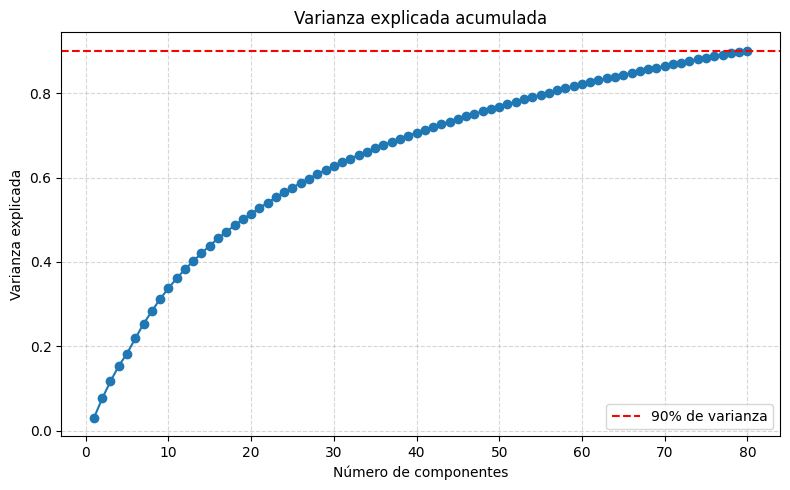

In [140]:
# Crear gráfico que muestra la varianza explicada acumulada por los componentes LSA

var_acumulada = np.cumsum(lsa.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_componentes + 1), var_acumulada, marker='o')
plt.axhline(y=0.9, color='red', linestyle='--', label="90% de varianza")
plt.title("Varianza explicada acumulada")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Los `80 componentes` que estamos seleccionando nos permiten capturar el 90,2% de la variacza acumulada, lo que implica que estmaos reteniedo mucha información. 


In [144]:
# Lista de valores a evaluar
componentes = [40, 60, 80, 100, 120]

print("Resumen de varianza explicada:")
print("-" * 50)

for n in componentes:
    lsa = TruncatedSVD(n_components=n, random_state=0)
    lsa.fit(tfidf_vectors)
    
    varianza = round(sum(lsa.explained_variance_ratio_) * 100, 3)
    print(f"{n} componentes explican {varianza}% de la varianza")


Resumen de varianza explicada:
--------------------------------------------------
40 componentes explican 70.605% de la varianza
60 componentes explican 82.09% de la varianza
80 componentes explican 90.16% de la varianza
100 componentes explican 95.561% de la varianza
120 componentes explican 98.991% de la varianza


Al aplicar el método LSA meediante `TruncatedSVD`sobre la matriz TF-IDF tenemos que:

* `80 componentes` principales explican el 90.2% de la varianza total del texto

* Se exploran también multiples opcciones de componentes, desde 40 hasta 120, para explorar el trade off entre comprensión y retención de información. Una menor cantidad de componentes simplifican el modelo pero sacrifican contexto mientras que mas componentes capturan más información pero puede aumentar el ruido.

En síntesis, la reducción de dimensionalidad ha sido efectiva, dado que 80 componentes parecen adecuados para mantenter un buen equilibrio entre simpleza y calidad semántica.


    

## Machine Learning | ***Aplicados sobre LSA***

### Regresión Logística

In [149]:
# Separar los datos 
X_lsa = tfidf_vectors_lsa
y = df_NPL['etiqueta']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_lsa, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Mostrar las dimensiones de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# Mostrar las dimensiones por clase en los conjuntos de entrenamiento y prueba
print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())
print("\nDistribución de clases en el conjunto de prueba:")
print(y_test.value_counts())



Tamaño del conjunto de entrenamiento: (180, 80)
Tamaño del conjunto de prueba: (46, 80)

Distribución de clases en el conjunto de entrenamiento:
etiqueta
Medio    111
Bajo      52
Grave     17
Name: count, dtype: int64

Distribución de clases en el conjunto de prueba:
etiqueta
Medio    29
Bajo     13
Grave     4
Name: count, dtype: int64


In [160]:
# Hiperparametriación para modelos

# El mejor KNN (K-Vecinos más cercanos)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Grid Search sobre KNN
param_grid = {'n_neighbors': list(range(2, 11))}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1_macro')
grid_knn.fit(X_train, y_train)

# EL mejor modelo encontrado
mejor_knn = grid_knn.best_estimator_

print("Mejor número de vecinos encontrado:", grid_knn.best_params_)


Mejor número de vecinos encontrado: {'n_neighbors': 4}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [161]:
# Entrenar varios modelos y evaluar su rendimiento 

# Definir los modelos a evaluar
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(random_state=42),
    "KNN con hiperparámetro": mejor_knn
}
# Entrenar y evaluar los modelos
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    print(f"\n Resultados con {nombre}:")
    print(classification_report(y_test, y_pred))



 Resultados con Regresión Logística:
              precision    recall  f1-score   support

        Bajo       1.00      0.08      0.14        13
       Grave       0.00      0.00      0.00         4
       Medio       0.64      1.00      0.78        29

    accuracy                           0.65        46
   macro avg       0.55      0.36      0.31        46
weighted avg       0.69      0.65      0.53        46


 Resultados con Random Forest:
              precision    recall  f1-score   support

        Bajo       0.00      0.00      0.00        13
       Grave       0.00      0.00      0.00         4
       Medio       0.61      0.93      0.74        29

    accuracy                           0.59        46
   macro avg       0.20      0.31      0.25        46
weighted avg       0.39      0.59      0.47        46


 Resultados con SVM:
              precision    recall  f1-score   support

        Bajo       0.00      0.00      0.00        13
       Grave       0.00      0.00    

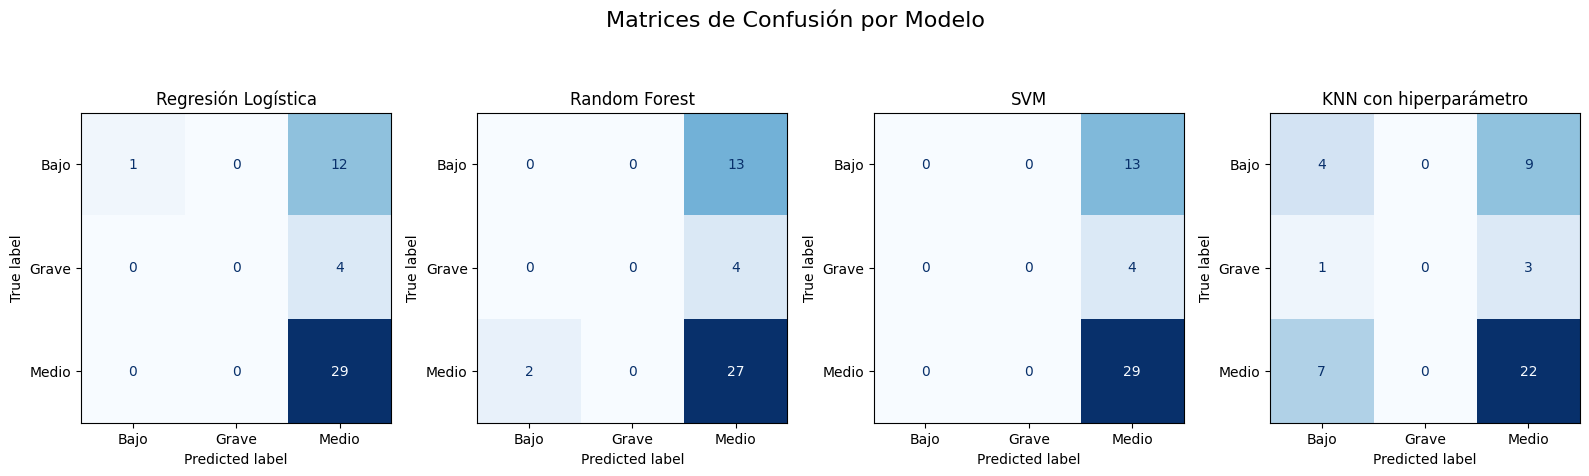

In [162]:

# Preparar figura
fig, axes = plt.subplots(1, len(modelos), figsize=(16, 5))
fig.suptitle("Matrices de Confusión por Modelo", fontsize=16)

# Iterar sobre los modelos y graficar su matriz
for ax, (nombre, modelo) in zip(axes, modelos.items()):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=modelo.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
    disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
    ax.set_title(nombre)

plt.tight_layout()
plt.show()


Análisis comparativo

- Indices de desempeño
    - `Accuracy`: los 3 modelos muestran un rendimiento modesto, aunque la `regresión logística`es lévemente mejor, no obstante esto no refleja un buen desempeño en todas las clases

- Comportamiento por clases
    - Las clases `Bajo`y `Grave`tienen problemas de detección, ninguno de los 3 modelos ha sido capaz de identificar correctamente. Esto sugiere un potencial problema de balanceo de clases. 
    